In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from pathlib import Path
import nibabel as nib
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.ndimage import label, binary_closing

# --- Configuration ---
CONFIG = {
    "image_size": 256,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    # Path to the CHAMPION MODEL (Exp 03)
    "model_path": "../models/exp03_attention_half_split/best_model.pth", 
    "manifest_path": "../data/UT-EndoMRI/D2_Half_Split/d2_half_split_manifest.csv",
    "data_root": "../data/UT-EndoMRI/D2_Half_Split"
}

print(f"Optimizing model: {CONFIG['model_path']}")

Optimizing model: ../models/exp03_attention_half_split/best_model.pth


In [2]:
# --- Model Architecture (Attention U-Net) ---
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
    def forward(self, g, x):
        g1 = self.W_g(g); x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        return x * self.psi(psi)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.double_conv(x)

class AttentionUNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1):
        super(AttentionUNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att1 = AttentionGate(F_g=512, F_l=512, F_int=256)
        self.conv1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att2 = AttentionGate(F_g=256, F_l=256, F_int=128)
        self.conv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att3 = AttentionGate(F_g=128, F_l=128, F_int=64)
        self.conv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att4 = AttentionGate(F_g=64, F_l=64, F_int=32)
        self.conv4 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        s1 = self.inc(x); s2 = self.down1(s1); s3 = self.down2(s2); s4 = self.down3(s3); s5 = self.down4(s4)
        d4 = self.up1(s5); s4_att = self.att1(g=d4, x=s4); d4 = torch.cat([d4, s4_att], dim=1); d4 = self.conv1(d4)
        d3 = self.up2(d4); s3_att = self.att2(g=d3, x=s3); d3 = torch.cat([d3, s3_att], dim=1); d3 = self.conv2(d3)
        d2 = self.up3(d3); s2_att = self.att3(g=d2, x=s2); d2 = torch.cat([d2, s2_att], dim=1); d2 = self.conv3(d2)
        d1 = self.up4(d2); s1_att = self.att4(g=d1, x=s1); d1 = torch.cat([d1, s1_att], dim=1); d1 = self.conv4(d1)
        return self.outc(d1)

# --- Dataset (Standard) ---
class OvaryDataset(Dataset):
    def __init__(self, root_dir, manifest_path, split, image_size=256):
        self.root_dir = Path(root_dir)
        self.df = pd.read_csv(manifest_path)
        self.df = self.df[self.df['split'] == split].reset_index(drop=True)
        self.image_size = image_size
        self.samples = [] 
        for idx, row in self.df.iterrows():
            img_p = self.root_dir / Path(row['t2fs_path']).name
            msk_p = self.root_dir / Path(row['ov_path']).name
            if not img_p.exists(): continue
            try:
                msk_vol = nib.load(str(msk_p)).get_fdata()
                z_sums = np.sum(msk_vol, axis=(0, 1))
                valid_slices = np.where(z_sums > 0)[0]
                for z in valid_slices:
                    self.samples.append({'img_path': str(img_p), 'msk_path': str(msk_p), 'slice_idx': z, 'pid': row['pid']})
            except: pass

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        info = self.samples[idx]
        img_vol = nib.load(info['img_path']).get_fdata()
        msk_vol = nib.load(info['msk_path']).get_fdata()
        z = info['slice_idx']
        img = img_vol[:, :, z]
        msk = msk_vol[:, :, z]
        
        p1 = np.percentile(img, 1); p99 = np.percentile(img, 99)
        img = np.clip(img, p1, p99)
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        msk = (msk > 0).astype(np.float32)
        
        img = torch.from_numpy(img.T).float().unsqueeze(0)
        msk = torch.from_numpy(msk.T).float().unsqueeze(0)
        img = TF.resize(img, [self.image_size, self.image_size], interpolation=TF.InterpolationMode.BILINEAR, antialias=True)
        msk = TF.resize(msk, [self.image_size, self.image_size], interpolation=TF.InterpolationMode.NEAREST, antialias=True)
        return img, msk

In [3]:
def postprocess_largest_component(binary_mask):
    """
    Keeps only the largest connected component in the 3D volume.
    Removes small floating blobs.
    """
    # Label connected components
    labeled_array, num_features = label(binary_mask)
    
    if num_features == 0:
        return binary_mask
    
    # Calculate size of each component
    component_sizes = np.bincount(labeled_array.ravel())
    
    # Ignore background (label 0)
    component_sizes[0] = 0
    
    # Find largest
    largest_label = component_sizes.argmax()
    
    # Create new mask
    new_mask = np.zeros_like(binary_mask)
    new_mask[labeled_array == largest_label] = 1
    
    return new_mask

In [4]:
def optimize_inference(model_path, dataset, device):
    # Load Model
    model = AttentionUNet(n_channels=1, n_classes=1).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Group by patient
    patient_data = {}
    for i, sample in enumerate(dataset.samples):
        pid = sample['pid']
        if pid not in patient_data: patient_data[pid] = []
        patient_data[pid].append(sample)
    
    thresholds = np.arange(0.1, 1.0, 0.1) # 0.1, 0.2 ... 0.9
    
    results = {t: {'raw': [], 'post': []} for t in thresholds}
    
    print("Running Optimization on Validation Set...")
    
    with torch.no_grad():
        for pid, samples in tqdm(patient_data.items(), desc="Patients"):
            samples.sort(key=lambda x: x['slice_idx'])
            
            # 1. Get Logits for whole volume
            vol_logits = []
            vol_gt = []
            
            for sample in samples:
                img_vol = nib.load(sample['img_path']).get_fdata()
                msk_vol = nib.load(sample['msk_path']).get_fdata()
                z = sample['slice_idx']
                img = img_vol[:, :, z]
                msk = msk_vol[:, :, z]
                
                # Preprocess
                p1 = np.percentile(img, 1); p99 = np.percentile(img, 99)
                img = np.clip(img, p1, p99)
                img = (img - img.min()) / (img.max() - img.min() + 1e-8)
                msk = (msk > 0).astype(np.float32)
                
                img_t = torch.from_numpy(img.T).float().unsqueeze(0).unsqueeze(0).to(device)
                img_t = TF.resize(img_t, [256, 256], interpolation=TF.InterpolationMode.BILINEAR, antialias=True)
                
                logits = model(img_t)
                prob = torch.sigmoid(logits).cpu().numpy().squeeze()
                
                # Resize GT to 256 for comparison
                msk_t = torch.from_numpy(msk.T).float().unsqueeze(0).unsqueeze(0)
                msk_t = TF.resize(msk_t, [256, 256], interpolation=TF.InterpolationMode.NEAREST, antialias=True)
                gt = msk_t.numpy().squeeze()
                
                vol_logits.append(prob)
                vol_gt.append(gt)
            
            vol_logits = np.array(vol_logits)
            vol_gt = np.array(vol_gt)
            
            # 2. Test Thresholds
            for t in thresholds:
                # Raw Thresholding
                pred_raw = (vol_logits > t).astype(np.float32)
                
                # Post-Processing (Keep Largest Component)
                pred_post = postprocess_largest_component(pred_raw)
                
                # Calculate Dice
                inter_raw = np.sum(pred_raw * vol_gt)
                total_raw = np.sum(pred_raw) + np.sum(vol_gt)
                dice_raw = (2.0 * inter_raw) / (total_raw + 1e-8)
                
                inter_post = np.sum(pred_post * vol_gt)
                total_post = np.sum(pred_post) + np.sum(vol_gt)
                dice_post = (2.0 * inter_post) / (total_post + 1e-8)
                
                results[t]['raw'].append(dice_raw)
                results[t]['post'].append(dice_post)
                
    return results

# Run on Validation Set (Fold 1)
val_ds = OvaryDataset(CONFIG["data_root"], CONFIG["manifest_path"], split='val')
results = optimize_inference(CONFIG["model_path"], val_ds, CONFIG["device"])

C:\Users\lytten\AppData\Local\Temp\ipykernel_22396\153182301.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Running Optimization on Validation Set...


Patients:   0%|          | 0/8 [00:00<?, ?it/s]

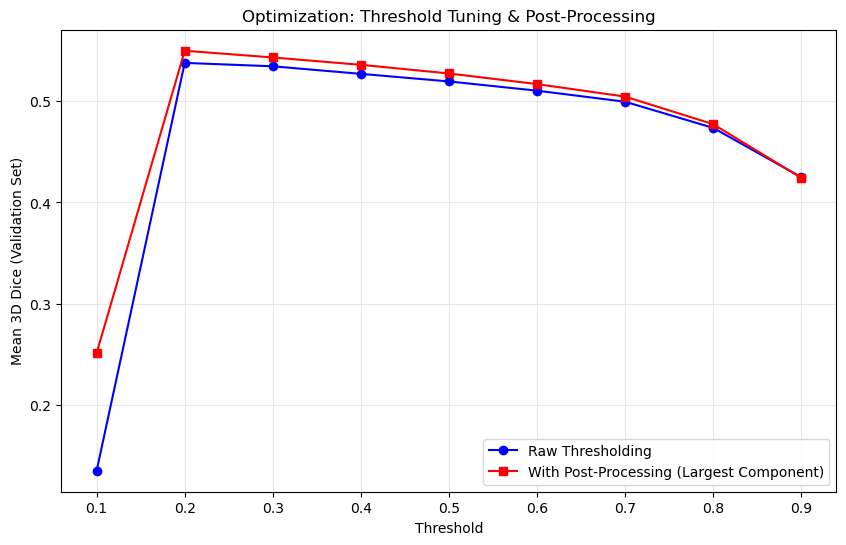

Best RAW Configuration: Threshold 0.2 -> Dice 0.5381
Best POST-PROC Config:  Threshold 0.2 -> Dice 0.5501

RECOMMENDATION: Use Threshold 0.2 WITH Post-Processing.


In [5]:
# Extract stats
thresh_vals = sorted(results.keys())
mean_raw = [np.mean(results[t]['raw']) for t in thresh_vals]
mean_post = [np.mean(results[t]['post']) for t in thresh_vals]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresh_vals, mean_raw, 'b-o', label='Raw Thresholding')
plt.plot(thresh_vals, mean_post, 'r-s', label='With Post-Processing (Largest Component)')
plt.xlabel('Threshold')
plt.ylabel('Mean 3D Dice (Validation Set)')
plt.title('Optimization: Threshold Tuning & Post-Processing')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(thresh_vals)
plt.show()

# Find Best
best_t_raw = thresh_vals[np.argmax(mean_raw)]
best_score_raw = max(mean_raw)

best_t_post = thresh_vals[np.argmax(mean_post)]
best_score_post = max(mean_post)

print(f"Best RAW Configuration: Threshold {best_t_raw:.1f} -> Dice {best_score_raw:.4f}")
print(f"Best POST-PROC Config:  Threshold {best_t_post:.1f} -> Dice {best_score_post:.4f}")

if best_score_post > best_score_raw:
    print(f"\nRECOMMENDATION: Use Threshold {best_t_post:.1f} WITH Post-Processing.")
else:
    print(f"\nRECOMMENDATION: Use Threshold {best_t_raw:.1f} WITHOUT Post-Processing.")

C:\Users\lytten\AppData\Local\Temp\ipykernel_22396\4253948556.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Visualizing Optimization Steps on 8 patients...


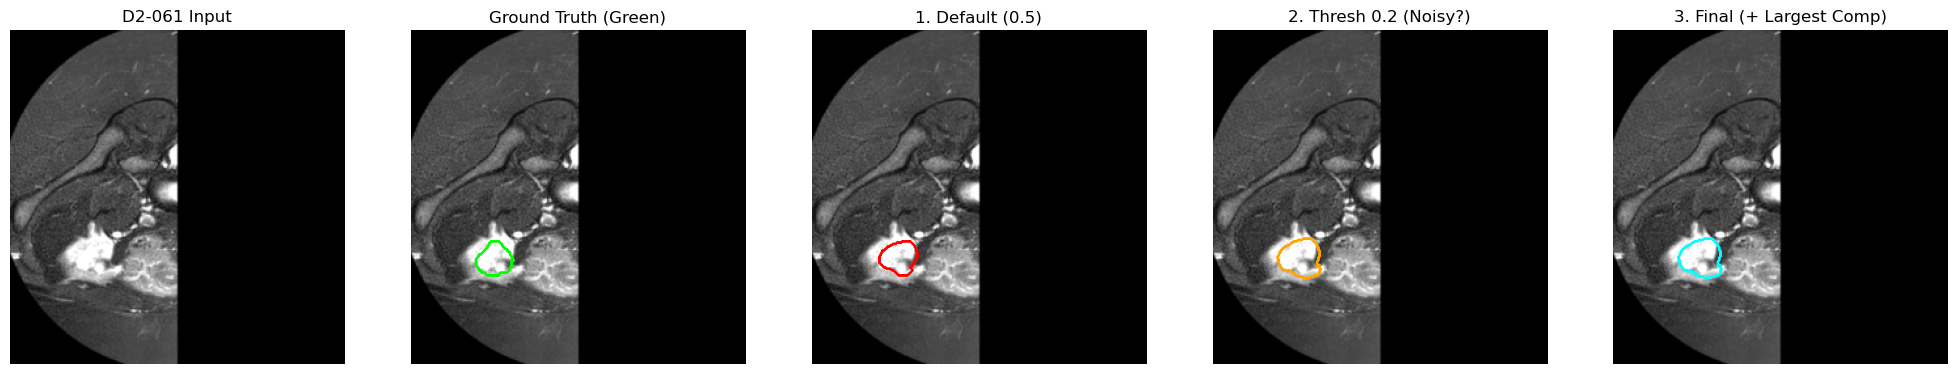

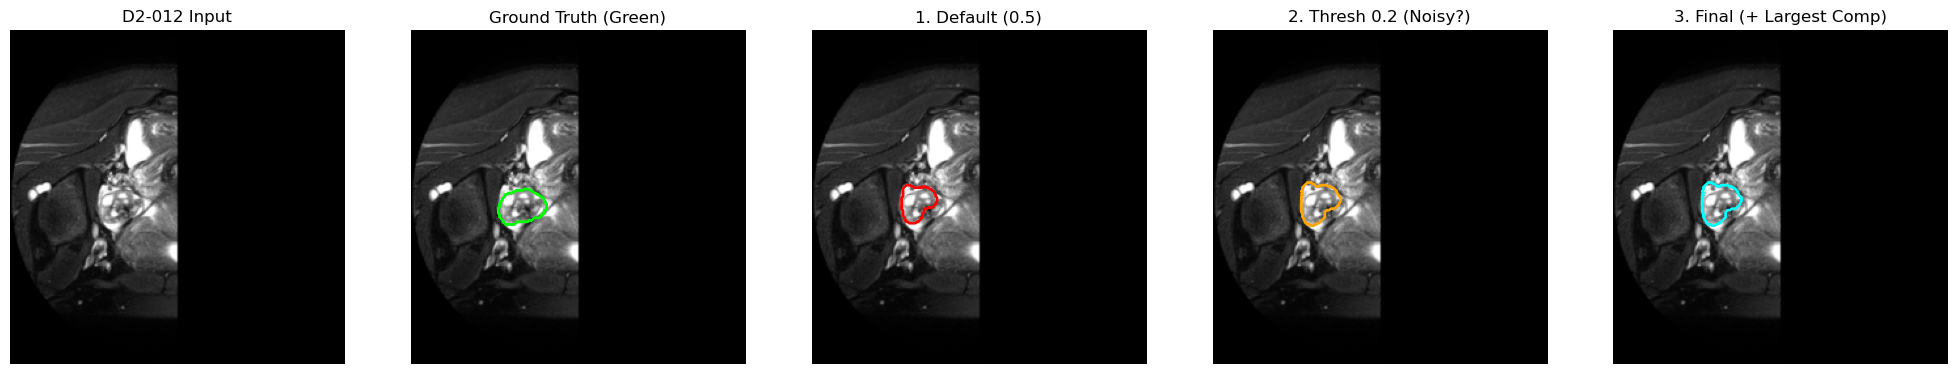

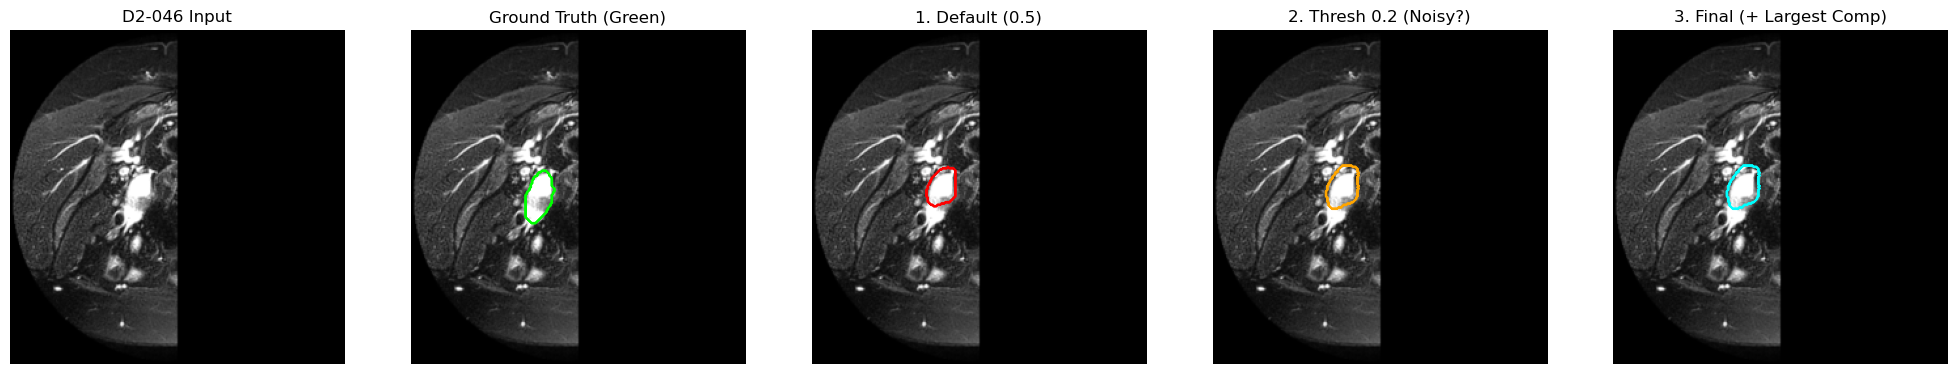

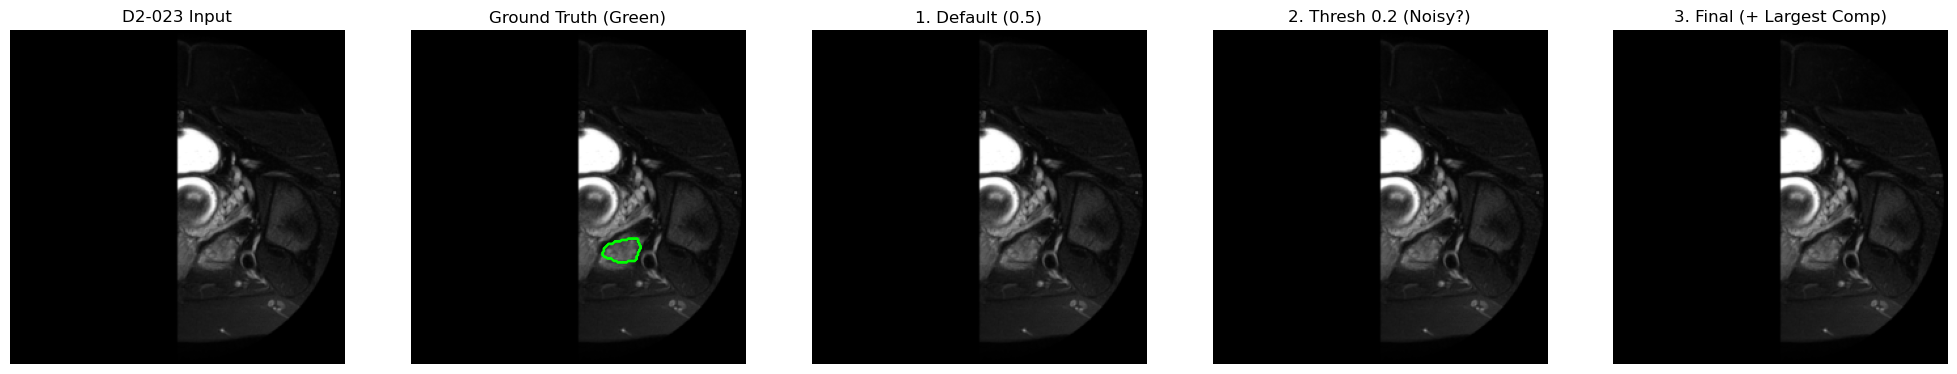

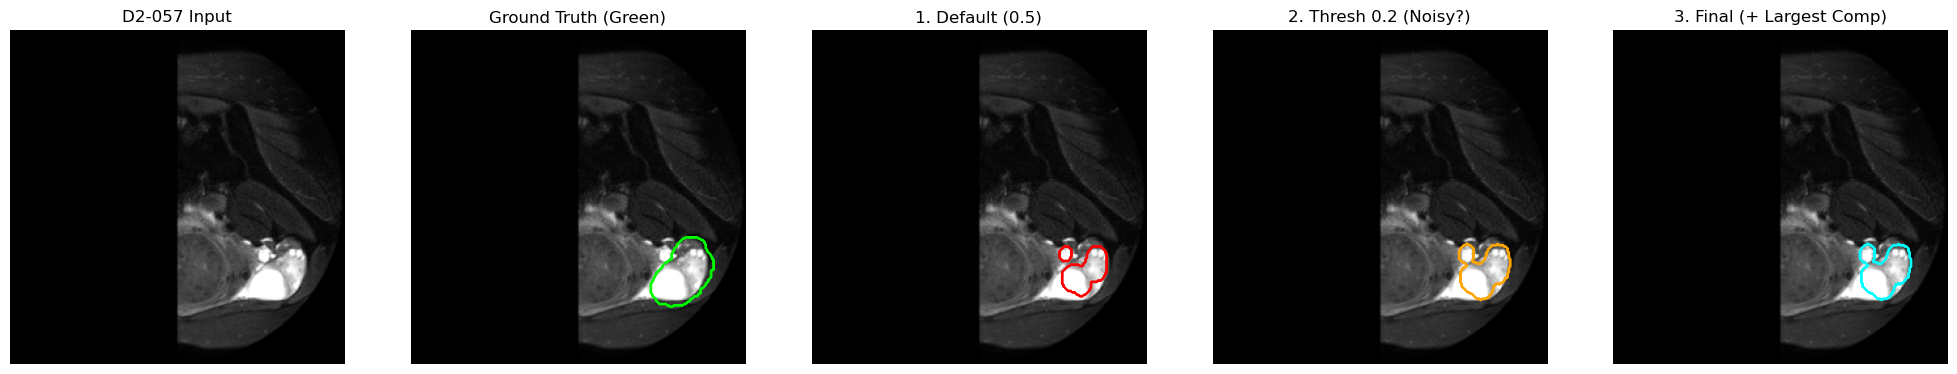

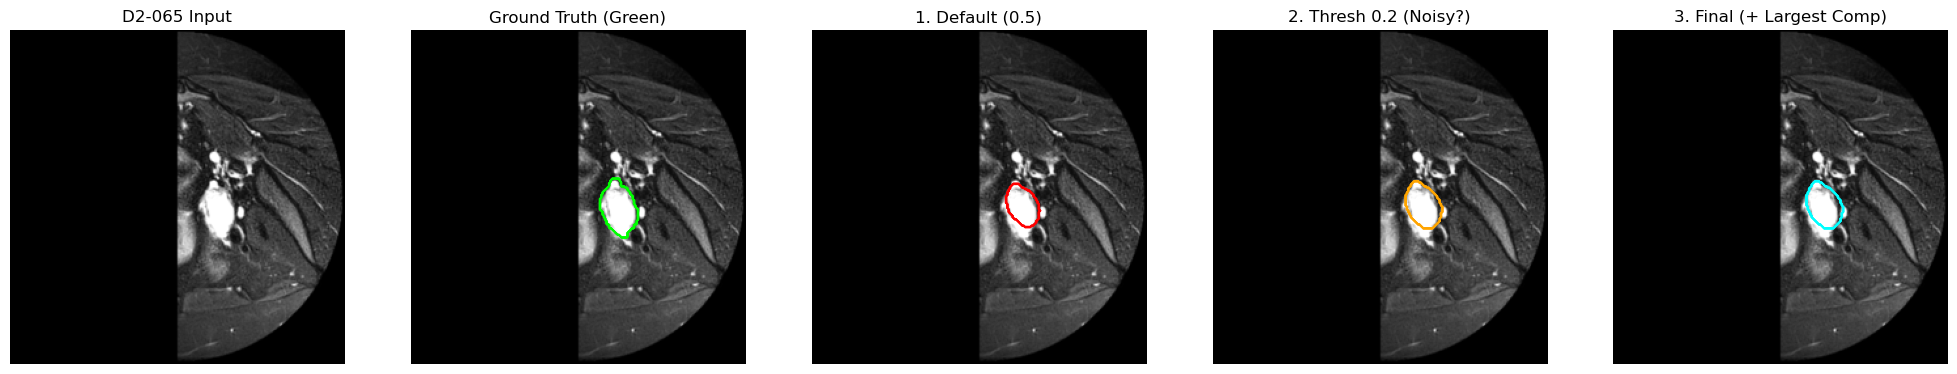

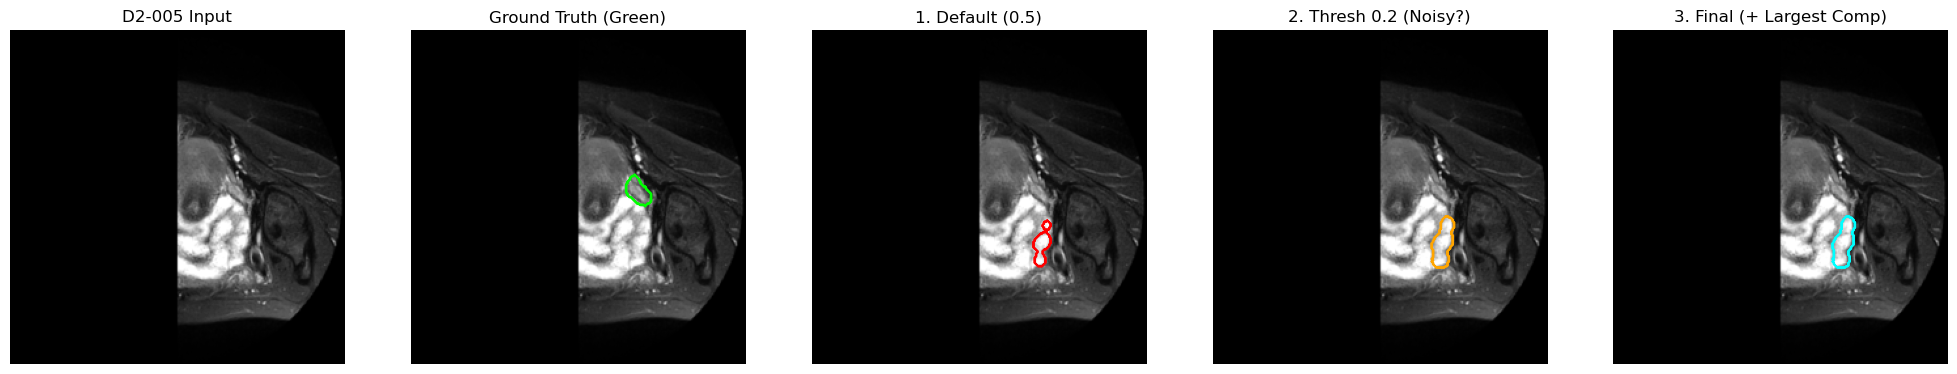

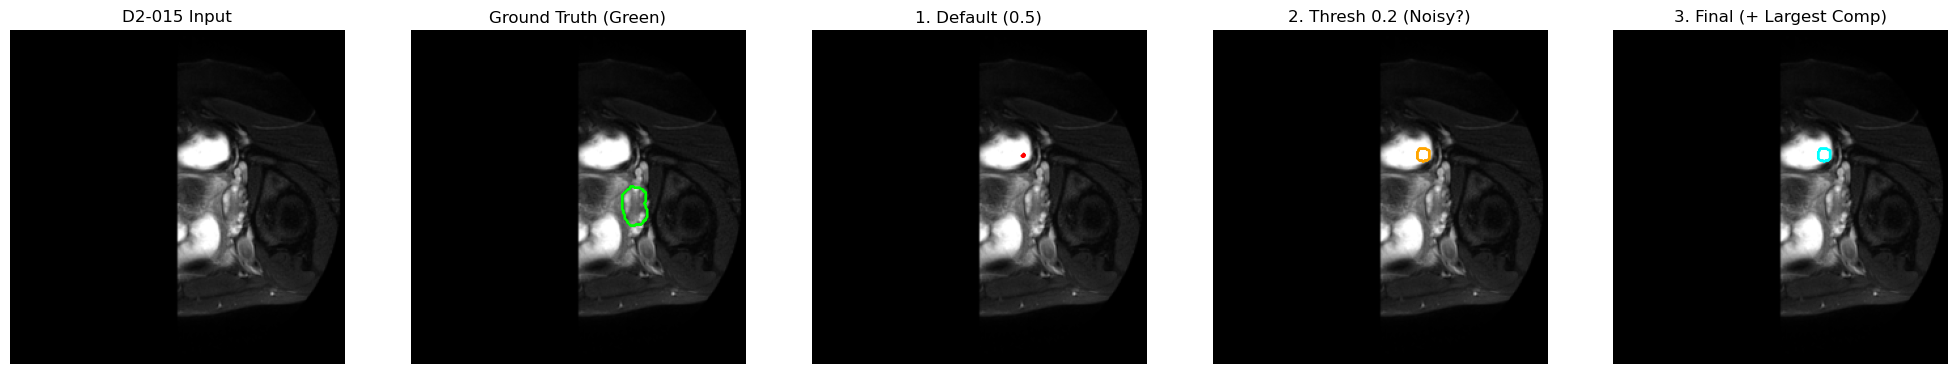

In [9]:
# VISUALIZATION: Step-by-Step Optimization (Validation Set)

def visualize_step_by_step(model_path, dataset, device, best_thresh):
    model = AttentionUNet(n_channels=1, n_classes=1).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Get all unique patients
    patient_ids = list(set([s['pid'] for s in dataset.samples]))
    random.shuffle(patient_ids)
    
    # Show up to 8 patients
    num_to_show = min(len(patient_ids), 8)
    selected_pids = patient_ids[:num_to_show]
    
    print(f"Visualizing Optimization Steps on {num_to_show} patients...")
    
    for pid in selected_pids:
        # Get all slices for this patient
        indices = [i for i, s in enumerate(dataset.samples) if s['pid'] == pid]
        indices.sort(key=lambda i: dataset.samples[i]['slice_idx'])
        
        if not indices: continue
        
        # Pick the "Best Slice" (most ovary pixels)
        best_slice_idx = -1
        max_pixels = -1
        for idx in indices:
            _, msk = dataset[idx]
            pixels = torch.sum(msk)
            if pixels > max_pixels:
                max_pixels = pixels
                best_slice_idx = idx
        
        if best_slice_idx == -1: best_slice_idx = indices[len(indices)//2]
        
        img, msk = dataset[best_slice_idx]
        
        # Predict
        input_t = img.unsqueeze(0).to(device)
        input_t = TF.resize(input_t, [256, 256], interpolation=TF.InterpolationMode.BILINEAR, antialias=True)
        
        with torch.no_grad():
            logits = model(input_t)
            prob = torch.sigmoid(logits).cpu().numpy().squeeze()
            
        # 1. Default (0.5)
        pred_default = (prob > 0.5).astype(np.float32)
        
        # 2. Lower Threshold Only
        pred_thresh = (prob > best_thresh).astype(np.float32)
        
        # 3. Threshold + Post-Processing
        pred_final = postprocess_largest_component(pred_thresh)
        
        # --- PLOTTING ---
        fig, axes = plt.subplots(1, 5, figsize=(25, 5))
        
        # Col 1: Input
        axes[0].imshow(img.squeeze(), cmap='gray', origin='lower')
        axes[0].set_title(f"{pid} Input")
        
        # Col 2: Ground Truth
        axes[1].imshow(img.squeeze(), cmap='gray', origin='lower')
        axes[1].contour(msk.squeeze(), colors='lime', linewidths=1)
        axes[1].set_title("Ground Truth (Green)")
        
        # Col 3: Default (0.5)
        axes[2].imshow(img.squeeze(), cmap='gray', origin='lower')
        if np.sum(pred_default) > 0:
            axes[2].contour(pred_default, colors='red', linewidths=1)
        axes[2].set_title("1. Default (0.5)")
        
        # Col 4: Thresh Only
        axes[3].imshow(img.squeeze(), cmap='gray', origin='lower')
        if np.sum(pred_thresh) > 0:
            axes[3].contour(pred_thresh, colors='orange', linewidths=1)
        axes[3].set_title(f"2. Thresh {best_thresh} (Noisy?)")
        
        # Col 5: Final (Thresh + PostProc)
        axes[4].imshow(img.squeeze(), cmap='gray', origin='lower')
        if np.sum(pred_final) > 0:
            axes[4].contour(pred_final, colors='cyan', linewidths=1)
        axes[4].set_title(f"3. Final (+ Largest Comp)")
        
        for ax in axes: ax.axis('off')
        plt.show()

# Run
best_t = 0.2 # Or whatever your optimization found
visualize_step_by_step(CONFIG["model_path"], val_ds, CONFIG["device"], best_t)

In [11]:
# VISUALIZATION: The "Difference Hunter" (Training Set)
# Fixed: Uses exact inference tensors for plotting to prevent coordinate mismatches.

def visualize_most_improved(model_path, root_dir, manifest_path, device, best_thresh):
    model = AttentionUNet(n_channels=1, n_classes=1).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # LOAD TRAINING SET
    dataset = OvaryDataset(root_dir, manifest_path, split='train')
    
    print(f"Scanning {len(dataset)} slices in Training Set...")
    
    patient_data = {}
    for i, sample in enumerate(dataset.samples):
        pid = sample['pid']
        if pid not in patient_data: patient_data[pid] = []
        patient_data[pid].append(sample)
        
    improvements = []
    
    with torch.no_grad():
        for pid, samples in tqdm(patient_data.items(), desc="Scanning"):
            samples.sort(key=lambda x: x['slice_idx'])
            
            vol_prob = []
            vol_gt = []
            vol_imgs = [] # Store the exact images used
            
            # 1. Inference
            for sample in samples:
                img_vol = nib.load(sample['img_path']).get_fdata()
                msk_vol = nib.load(sample['msk_path']).get_fdata()
                z = sample['slice_idx']
                img = img_vol[:, :, z]
                msk = msk_vol[:, :, z]
                
                # Preprocess
                p1 = np.percentile(img, 1); p99 = np.percentile(img, 99)
                img = np.clip(img, p1, p99)
                img = (img - img.min()) / (img.max() - img.min() + 1e-8)
                msk = (msk > 0).astype(np.float32)
                
                img_t = torch.from_numpy(img.T).float().unsqueeze(0).unsqueeze(0).to(device)
                img_t = TF.resize(img_t, [256, 256], interpolation=TF.InterpolationMode.BILINEAR, antialias=True)
                
                logits = model(img_t)
                prob = torch.sigmoid(logits).cpu().numpy().squeeze()
                
                # Resize GT
                msk_t = torch.from_numpy(msk.T).float().unsqueeze(0).unsqueeze(0)
                msk_t = TF.resize(msk_t, [256, 256], interpolation=TF.InterpolationMode.NEAREST, antialias=True)
                gt = msk_t.numpy().squeeze()
                
                # Save exact image for plotting (squeeze to 2D)
                img_disp = img_t.cpu().numpy().squeeze()
                
                vol_prob.append(prob)
                vol_gt.append(gt)
                vol_imgs.append(img_disp)
            
            vol_prob = np.array(vol_prob)
            vol_gt = np.array(vol_gt)
            
            # 2. Compare Strategies
            # A: Default (0.5)
            pred_A = (vol_prob > 0.5).astype(np.float32)
            dice_A = (2.0 * np.sum(pred_A * vol_gt)) / (np.sum(pred_A) + np.sum(vol_gt) + 1e-8)
            
            # B: Optimized
            pred_B_raw = (vol_prob > best_thresh).astype(np.float32)
            pred_B = postprocess_largest_component(pred_B_raw)
            dice_B = (2.0 * np.sum(pred_B * vol_gt)) / (np.sum(pred_B) + np.sum(vol_gt) + 1e-8)
            
            diff = dice_B - dice_A
            
            # Only store if there is actual improvement
            if diff > 0.001:
                improvements.append({
                    'pid': pid,
                    'diff': diff,
                    'dice_A': dice_A,
                    'dice_B': dice_B,
                    'vol_prob': vol_prob,
                    'vol_gt': vol_gt,
                    'vol_imgs': vol_imgs,
                    'samples': samples
                })
    
    # Sort by improvement
    improvements.sort(key=lambda x: x['diff'], reverse=True)
    
    # Show Top 10
    top_n = improvements[:10]
    print(f"\nTop {len(top_n)} Most Improved Patients:")
    
    for item in top_n:
        print(f"{item['pid']}: Dice 0.5={item['dice_A']:.3f} -> Optimized={item['dice_B']:.3f} (Diff: +{item['diff']:.3f})")
        
        # Find best slice
        best_slice_idx = -1
        max_pixels = -1
        for i, slc_gt in enumerate(item['vol_gt']):
            if np.sum(slc_gt) > max_pixels:
                max_pixels = np.sum(slc_gt)
                best_slice_idx = i
        
        if best_slice_idx == -1: best_slice_idx = len(item['vol_gt']) // 2

        # Get data for this slice
        img_disp = item['vol_imgs'][best_slice_idx]
        gt_slice = item['vol_gt'][best_slice_idx]
        prob_slice = item['vol_prob'][best_slice_idx]
        
        pred_def = (prob_slice > 0.5).astype(np.float32)
        pred_thresh = (prob_slice > best_thresh).astype(np.float32)
        # Hack 2D postproc for viz
        pred_final = postprocess_largest_component(pred_thresh)
        
        # Plot
        fig, axes = plt.subplots(1, 5, figsize=(25, 5))
        
        axes[0].imshow(img_disp, cmap='gray', origin='lower')
        axes[0].set_title(f"{item['pid']} Input")
        
        axes[1].imshow(img_disp, cmap='gray', origin='lower')
        axes[1].contour(gt_slice, colors='lime', linewidths=1)
        axes[1].set_title("Ground Truth")
        
        axes[2].imshow(img_disp, cmap='gray', origin='lower')
        if np.sum(pred_def) > 0: axes[2].contour(pred_def, colors='red', linewidths=1)
        axes[2].set_title(f"Default 0.5\nDice: {item['dice_A']:.3f}")
        
        axes[3].imshow(img_disp, cmap='gray', origin='lower')
        if np.sum(pred_thresh) > 0: axes[3].contour(pred_thresh, colors='orange', linewidths=1)
        axes[3].set_title(f"Thresh {best_thresh}\n(Sensitivity)")
        
        axes[4].imshow(img_disp, cmap='gray', origin='lower')
        if np.sum(pred_final) > 0: axes[4].contour(pred_final, colors='cyan', linewidths=1)
        axes[4].set_title(f"Final (Post-Proc)\nDice: {item['dice_B']:.3f}")
        
        for ax in axes: ax.axis('off')
        plt.show()

# Run
best_t = 0.2
visualize_most_improved(CONFIG["model_path"], CONFIG["data_root"], CONFIG["manifest_path"], CONFIG["device"], best_t)

C:\Users\lytten\AppData\Local\Temp\ipykernel_22396\14212774.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Scanning 101 slices in Training Set...


Scanning:   0%|          | 0/21 [00:00<?, ?it/s]


Top 0 Most Improved Patients:
